In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from source.network.ravepqmf import PQMF
import librosa
from source.network.metrics import spectral_distance, multiscale_stft

def load_audio(file_path, sr=44100):
    audio, _ = librosa.load(file_path, sr=sr)
    return torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0)

def plot_waveform(signal, title):
    plt.figure(figsize=(12, 4))
    plt.plot(signal.squeeze().numpy())
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def plot_spectrogram(signal, sr, title):
    D = librosa.stft(signal.squeeze().numpy())
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def plot_frequency_domain(signal, sample_rate=44100, title=''):
    fft = np.fft.fft(signal.squeeze().numpy())
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    plt.figure(figsize=(12, 4))
    plt.xscale("log")
    plt.plot(freqs, np.abs(fft))
    plt.title(title)
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xscale('log')
    plt.show()

def plot_spectral_distance(x_stfts, y_stfts, scales):
    for i, scale in enumerate(scales):
        plt.figure(figsize=(12, 4))
        plt.imshow(np.abs(y_stfts[i][0] - x_stfts[i][0]).numpy().T, aspect='auto', cmap='viridis')
        plt.gca().invert_yaxis()
        plt.title(f'Spectral Distance (scale {scale})')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time Frame')
        plt.ylabel('Frequency Bin')
        plt.show()

def lin_distance(x, y):
    return torch.norm(x - y) / torch.norm(x)

def log_distance(x, y):
    return abs(torch.log(x + 1e-7) - torch.log(y + 1e-7)).mean()



## Spectral Distance

c:\Users\maxim\Documents\TUBerlin\neural-reverb-emulation\venv\Lib\site-packages\matplotlib\axes\_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


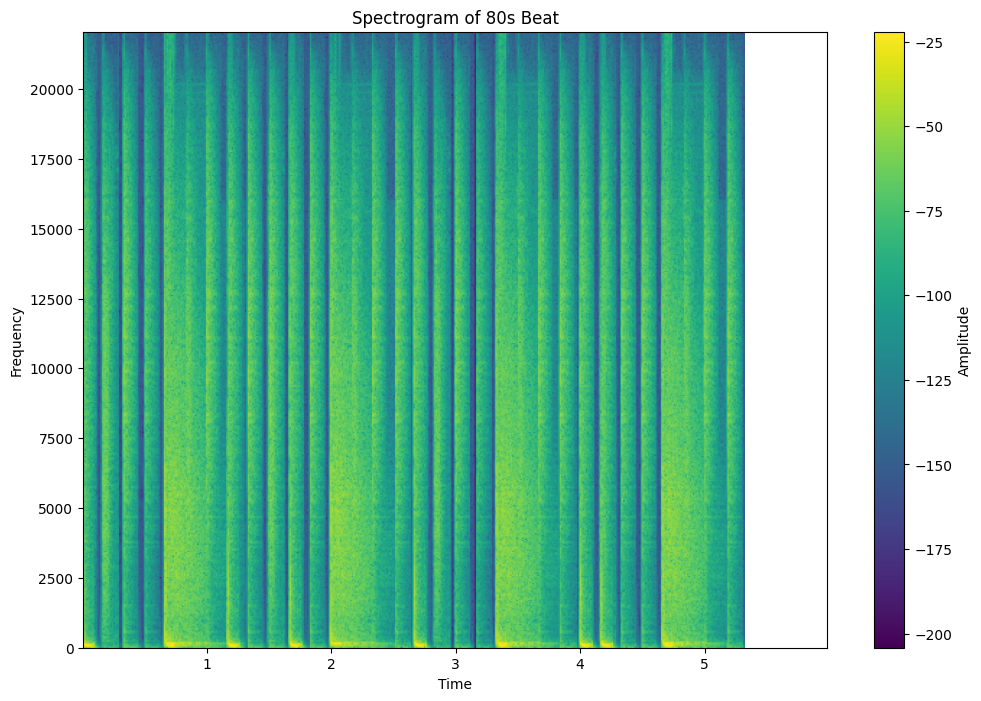

In [40]:
signal = load_audio("80s Beat 90 bpm_dry.wav").squeeze()
wet= load_audio("80s Beat 90 bpm_wet.wav").squeeze()


nfft = 1024
window = np.hanning(nfft)
sampling_rate = 44100
n_windows = 5
hop_length = nfft // 2

# Calculate and plot the spectrogram
plt.figure(figsize=(12, 8))
plt.specgram(signal, NFFT=nfft, Fs=sampling_rate, noverlap=hop_length, cmap='viridis')
plt.title('Spectrogram of 80s Beat')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Amplitude')
plt.show()

In [41]:
stft = np.abs(np.array([np.fft.fft(signal[i:i+nfft] * window) for i in range(0, len(signal) - nfft, hop_length)]))
print(stft.shape)
stft = np.abs(np.array([np.fft.rfft(signal[i:i+nfft] * window) for i in range(0, len(signal) - nfft, hop_length)]))

(515, 1024)


Spectral distance between original and reconstructed: 15.999296188354492


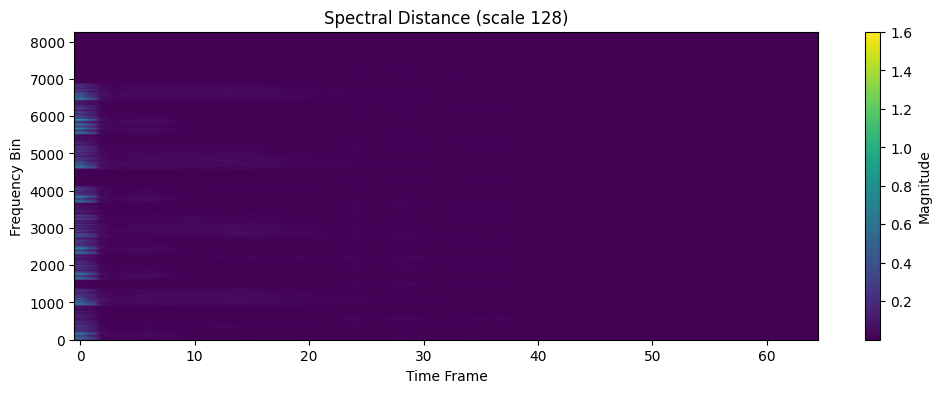

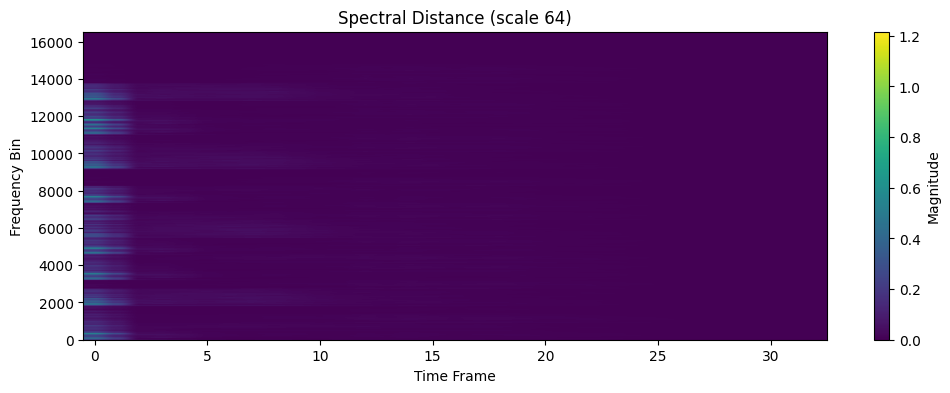

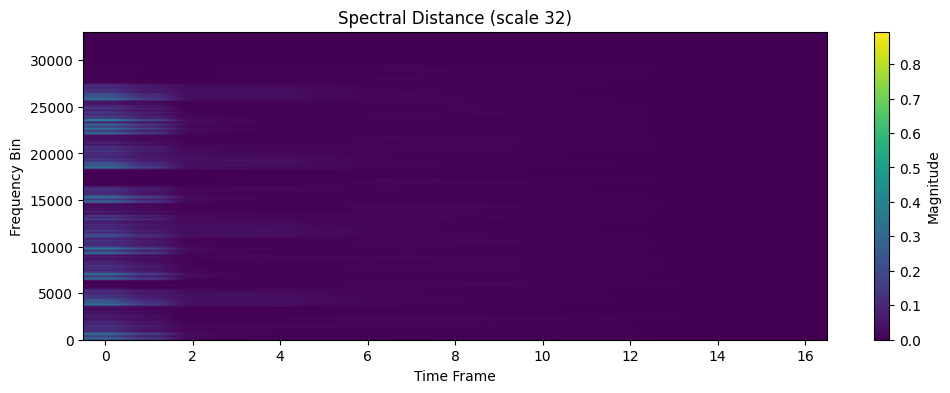

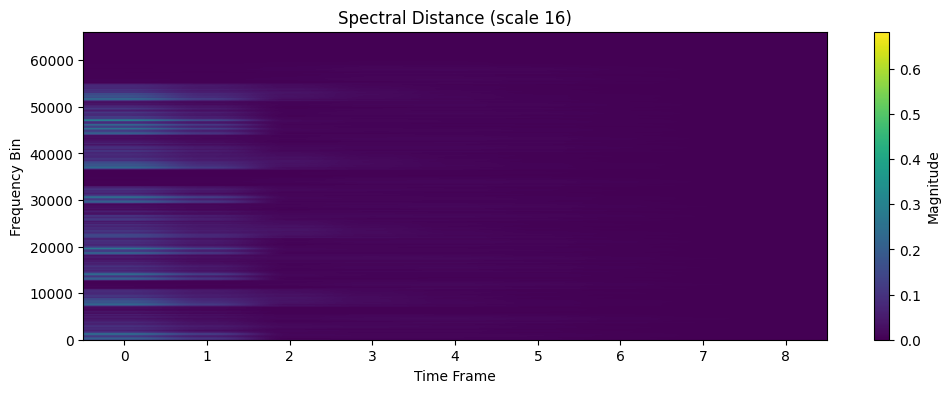

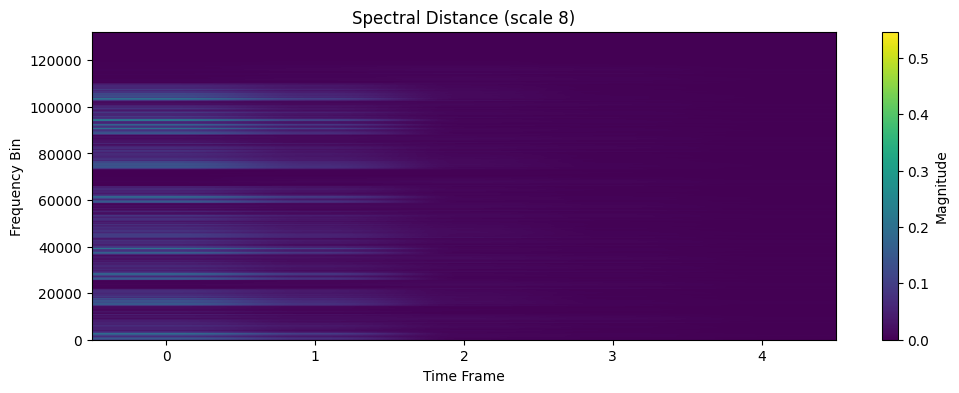

In [42]:
signal = load_audio("80s Beat 90 bpm_dry.wav")
wet= load_audio("80s Beat 90 bpm_wet.wav")

scales = [128, 64, 32, 16, 8]
distance = spectral_distance(signal, wet, scales)
print(f"Spectral distance between original and reconstructed: {distance.item()}")


x_stfts = multiscale_stft(signal, scales, .75)
y_stfts = multiscale_stft(wet, scales, .75)

plot_spectral_distance(x_stfts, y_stfts, scales)



In [43]:
def plot_spectrogram(stft, scale):
    plt.figure(figsize=(10, 4))
    plt.imshow(stft.squeeze().T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'(Scale: {scale})')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_distance_spectrogram(x_stft, y_stft, scale):
    distance = torch.abs(x_stft - y_stft)
    plot_spectrogram(distance, scale)

Spectral distance between original and processed: 14.198342323303223
STFT Summary for Original and Processed Signals:

Scale: 2048
Original Signal STFT:
{'shape': torch.Size([1, 1025, 517]), 'mean': 0.01746498793363571, 'std': 0.11467111110687256, 'min': 0.0, 'max': 8.293968200683594}


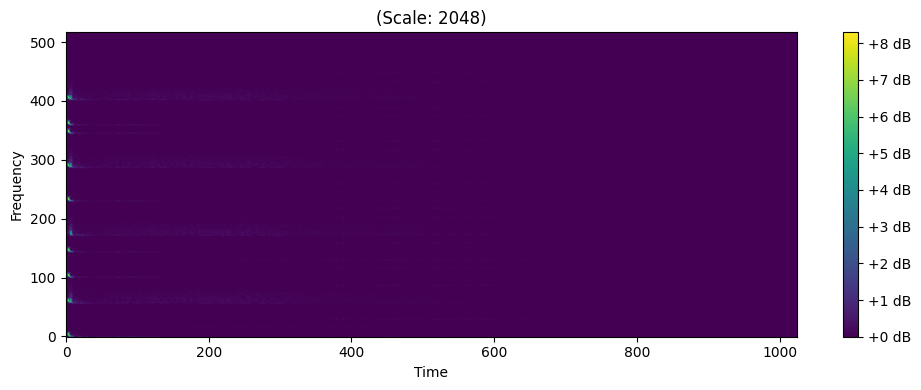

Processed Signal STFT:
{'shape': torch.Size([1, 1025, 517]), 'mean': 0.02038964070379734, 'std': 0.09790150821208954, 'min': 4.812729059722187e-08, 'max': 6.753482818603516}


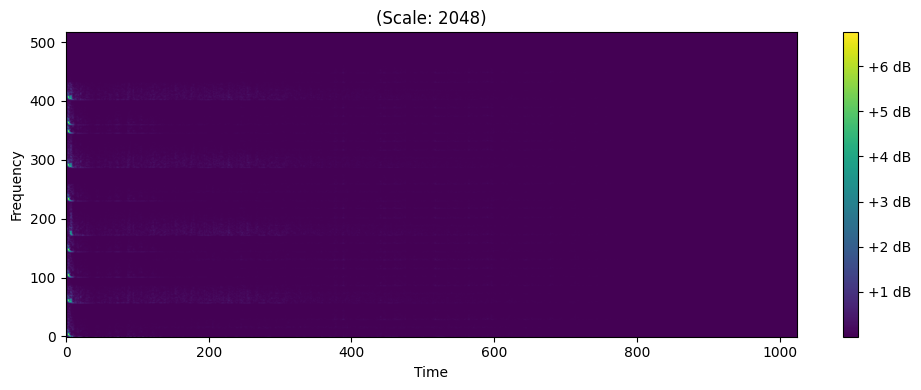

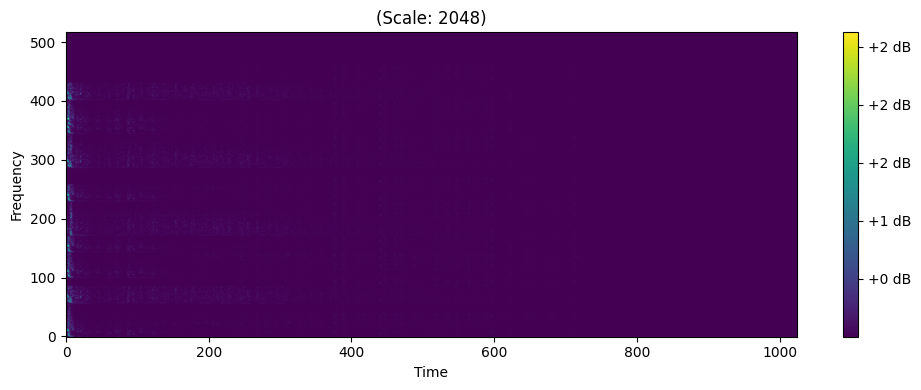

Linear distance: 0.3266089856624603
Log distance: 2.0091965198516846

Scale: 1024
Original Signal STFT:
{'shape': torch.Size([1, 513, 1034]), 'mean': 0.01718163676559925, 'std': 0.11499321460723877, 'min': 0.0, 'max': 7.399792194366455}


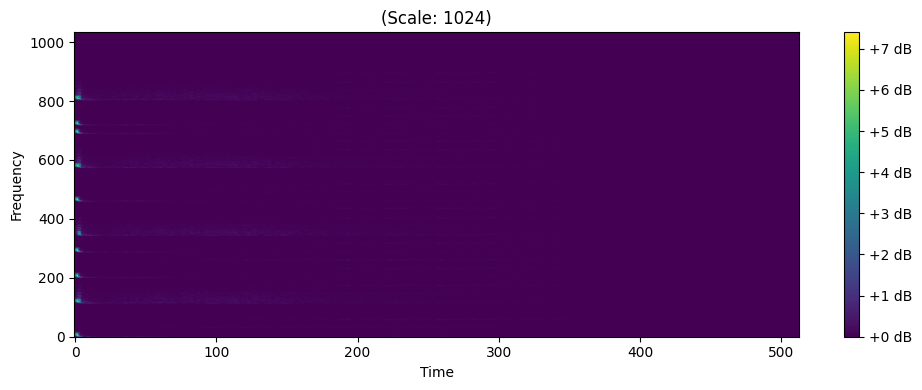

Processed Signal STFT:
{'shape': torch.Size([1, 513, 1034]), 'mean': 0.020624930039048195, 'std': 0.09830963611602783, 'min': 3.566612605254704e-08, 'max': 5.851319789886475}


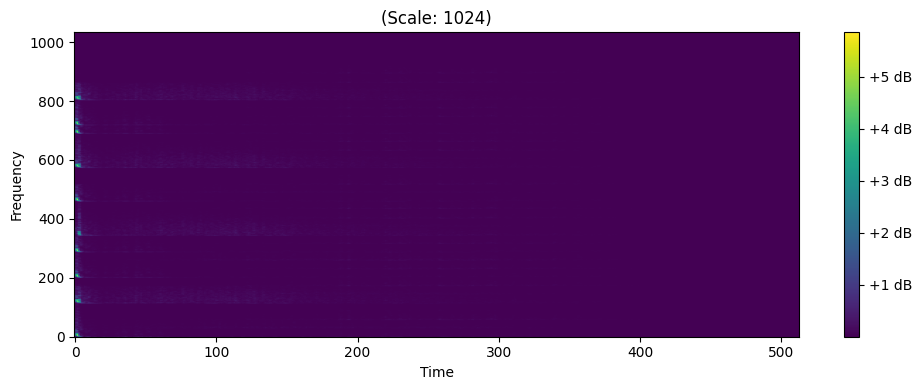

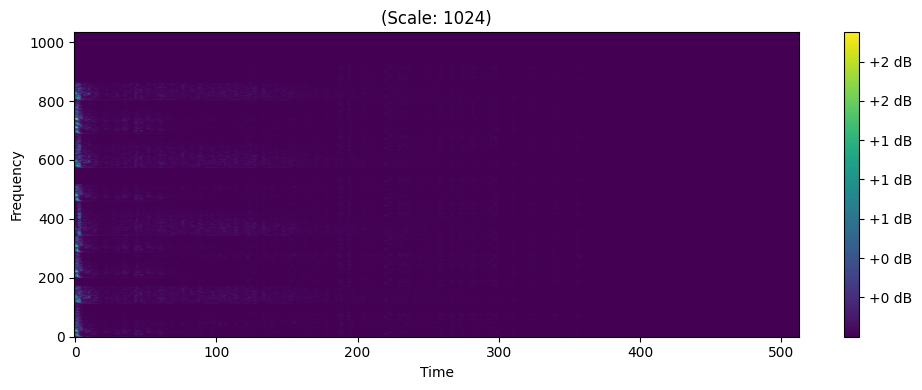

Linear distance: 0.3309609889984131
Log distance: 2.3888370990753174

Scale: 512
Original Signal STFT:
{'shape': torch.Size([1, 257, 2067]), 'mean': 0.017820248380303383, 'std': 0.12324557453393936, 'min': 0.0, 'max': 6.1009321212768555}


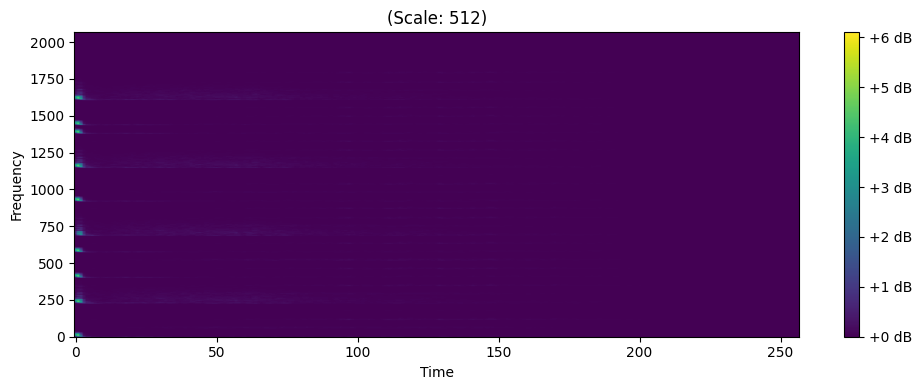

Processed Signal STFT:
{'shape': torch.Size([1, 257, 2067]), 'mean': 0.021644359454512596, 'std': 0.10554917901754379, 'min': 1.4901161193847656e-08, 'max': 4.953650951385498}


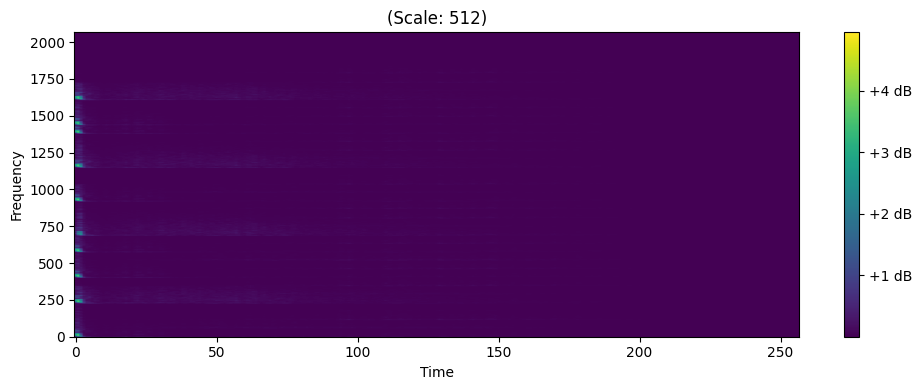

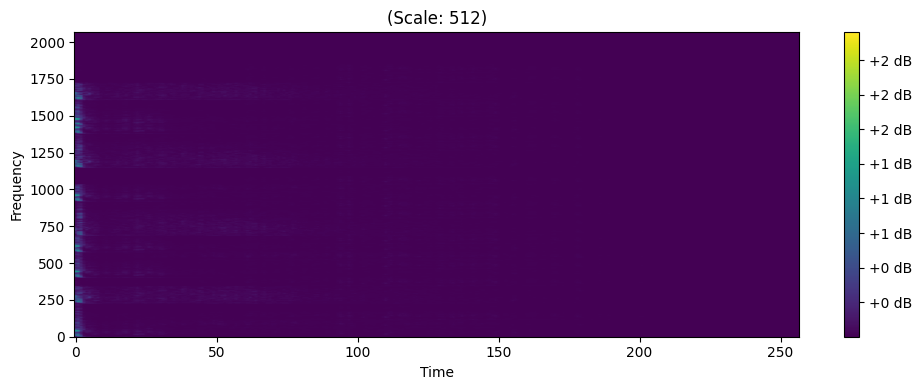

Linear distance: 0.3326576352119446
Log distance: 2.6054532527923584

Scale: 256
Original Signal STFT:
{'shape': torch.Size([1, 129, 4134]), 'mean': 0.019211482256650925, 'std': 0.13534100353717804, 'min': 0.0, 'max': 7.149750232696533}


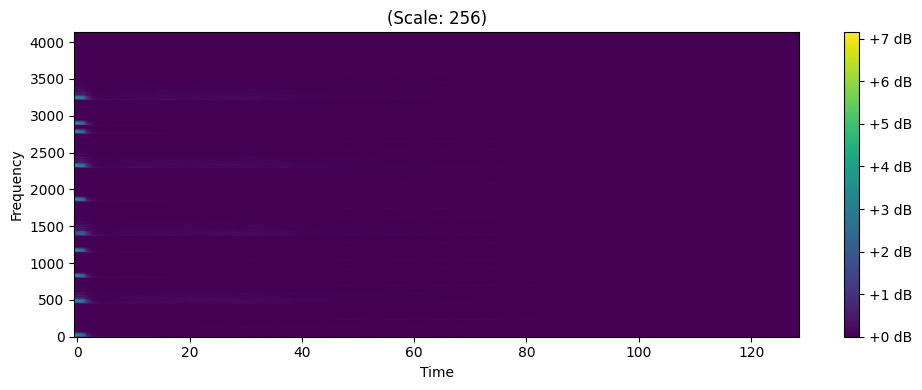

Processed Signal STFT:
{'shape': torch.Size([1, 129, 4134]), 'mean': 0.023222878575325012, 'std': 0.1153535470366478, 'min': 2.2351741790771484e-08, 'max': 5.667441368103027}


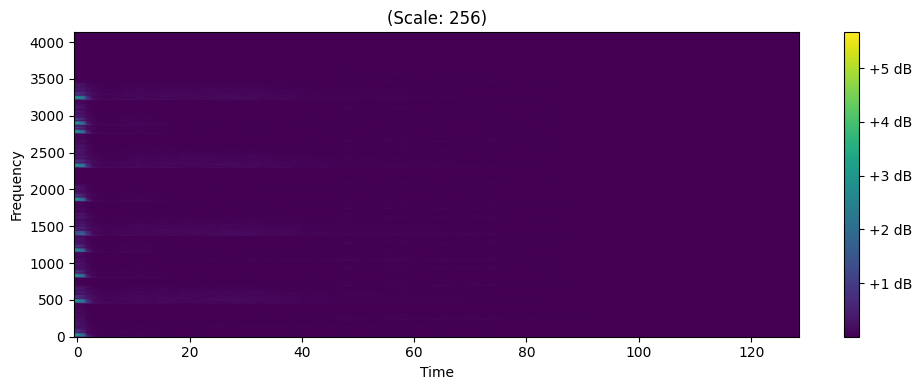

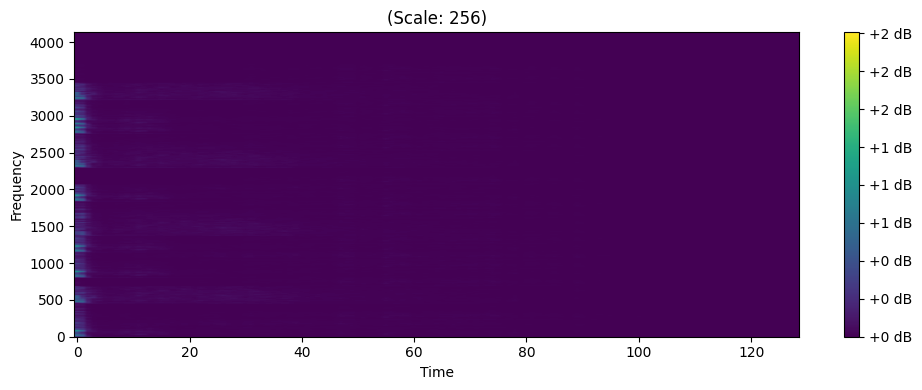

Linear distance: 0.32984909415245056
Log distance: 2.7357027530670166

Scale: 128
Original Signal STFT:
{'shape': torch.Size([1, 65, 8268]), 'mean': 0.0211277324706316, 'std': 0.14124245941638947, 'min': 0.0, 'max': 5.5298871994018555}


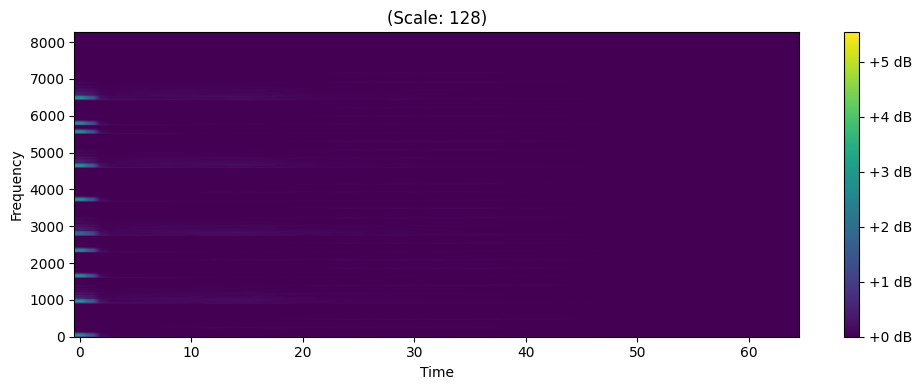

Processed Signal STFT:
{'shape': torch.Size([1, 65, 8268]), 'mean': 0.025330986827611923, 'std': 0.12001930177211761, 'min': 3.9101080706593905e-10, 'max': 4.683314323425293}


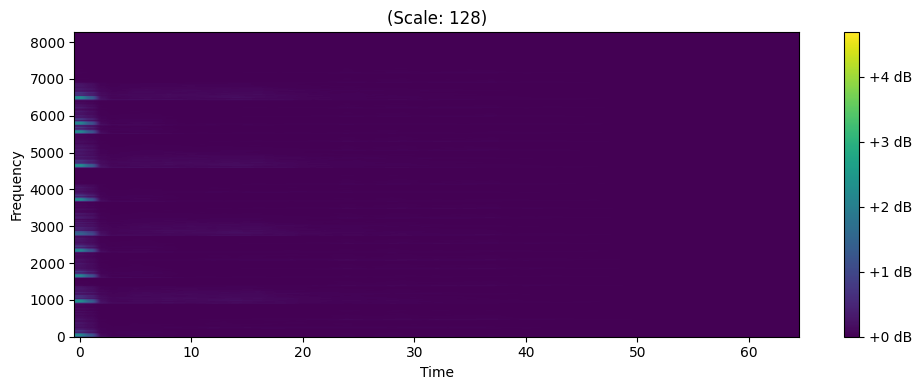

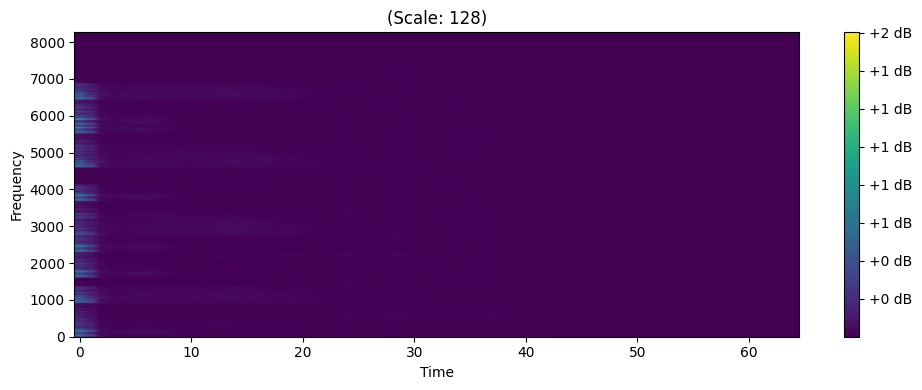

Linear distance: 0.3296471834182739
Log distance: 2.8094289302825928

Scale: 64
Original Signal STFT:
{'shape': torch.Size([1, 33, 16536]), 'mean': 0.023849859833717346, 'std': 0.14198057353496552, 'min': 0.0, 'max': 3.9722063541412354}


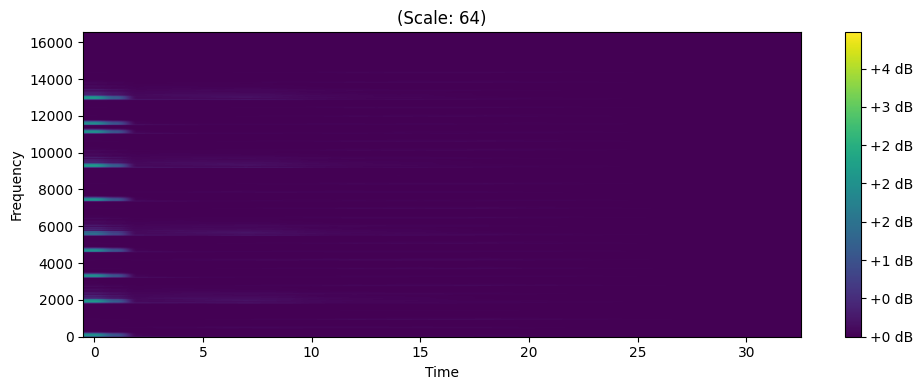

Processed Signal STFT:
{'shape': torch.Size([1, 33, 16536]), 'mean': 0.028286367654800415, 'std': 0.12037181109189987, 'min': 0.0, 'max': 3.443887233734131}


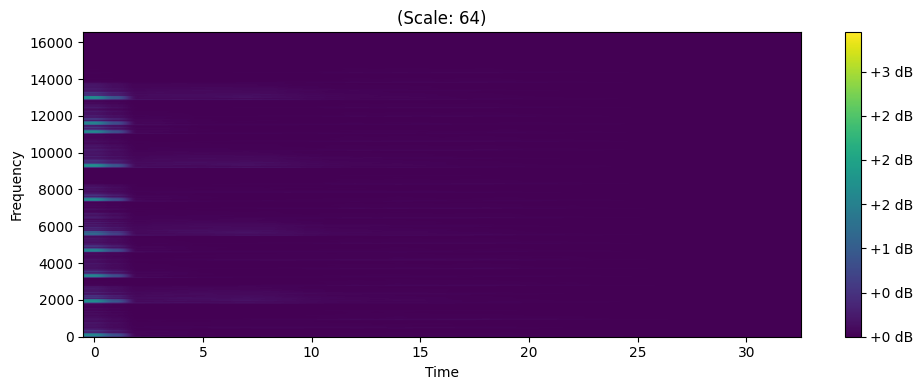

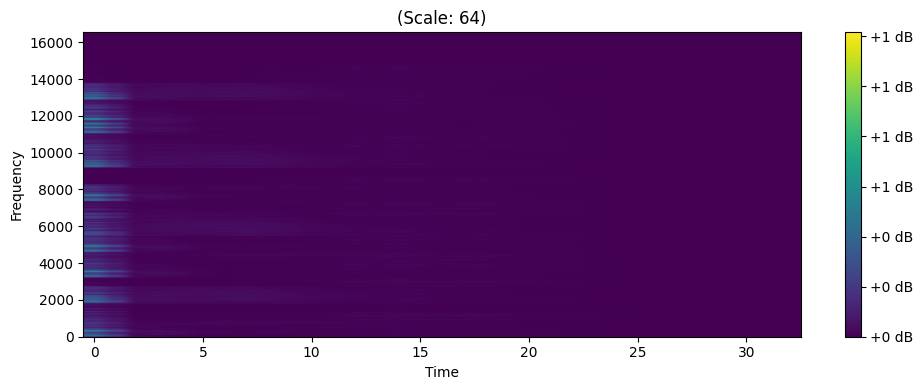

Linear distance: 0.33128821849823
Log distance: 2.848207950592041

Scale: 32
Original Signal STFT:
{'shape': torch.Size([1, 17, 33072]), 'mean': 0.02743951603770256, 'std': 0.1398853212594986, 'min': 0.0, 'max': 2.8277626037597656}


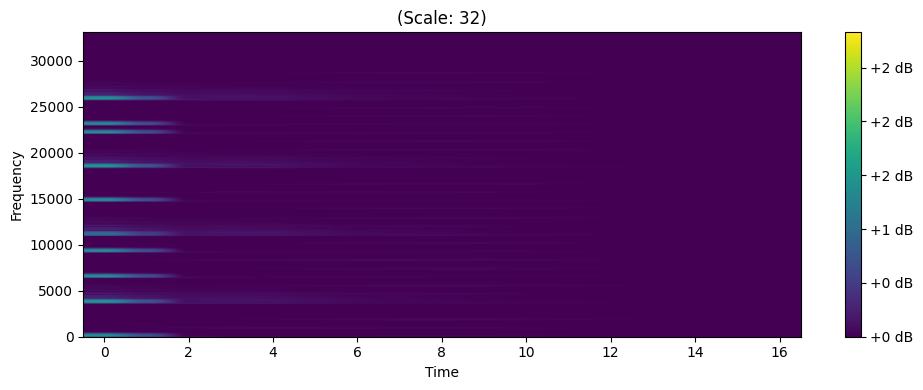

Processed Signal STFT:
{'shape': torch.Size([1, 17, 33072]), 'mean': 0.03209163248538971, 'std': 0.11819543689489365, 'min': 1.3096723705530167e-10, 'max': 2.5042691230773926}


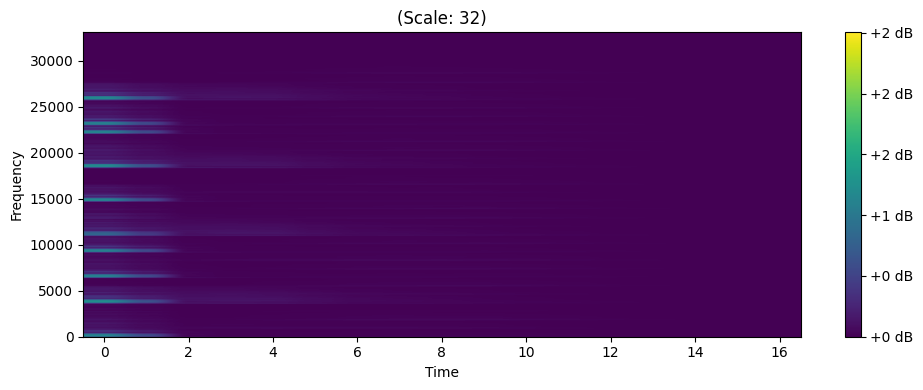

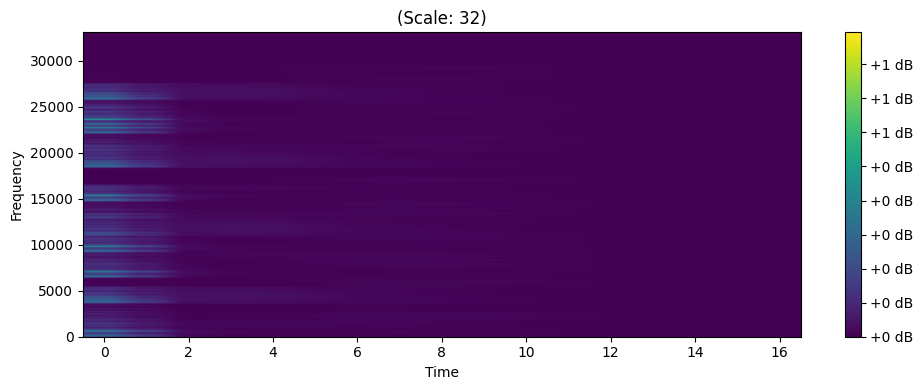

Linear distance: 0.33224835991859436
Log distance: 2.865351438522339

Scale: 16
Original Signal STFT:
{'shape': torch.Size([1, 9, 66144]), 'mean': 0.031747959554195404, 'std': 0.13529889285564423, 'min': 0.0, 'max': 2.0}


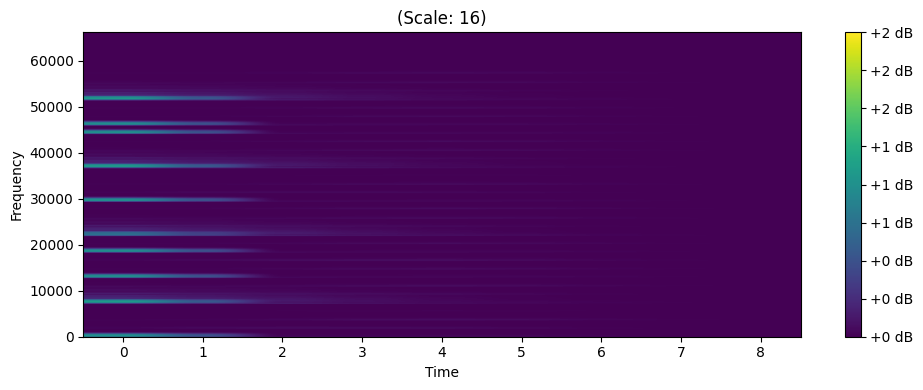

Processed Signal STFT:
{'shape': torch.Size([1, 9, 66144]), 'mean': 0.03661050274968147, 'std': 0.11374061554670334, 'min': 4.220055416226387e-10, 'max': 1.8412854671478271}


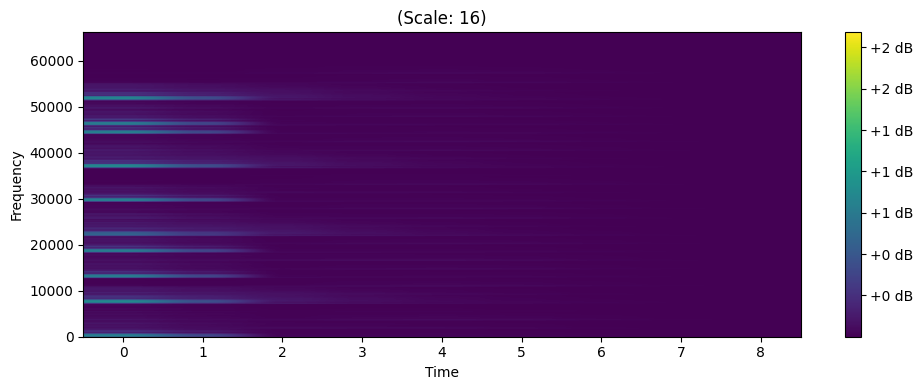

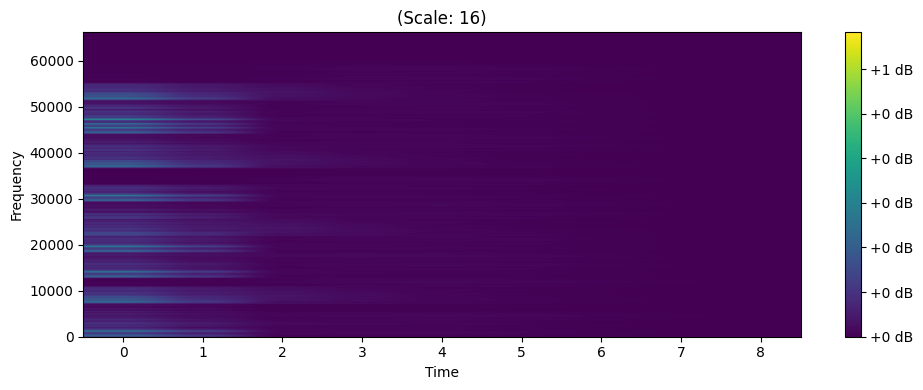

Linear distance: 0.3336798846721649
Log distance: 2.8940377235412598

Scale: 8
Original Signal STFT:
{'shape': torch.Size([1, 5, 132287]), 'mean': 0.03647185489535332, 'std': 0.1273268461227417, 'min': 0.0, 'max': 1.4142134189605713}


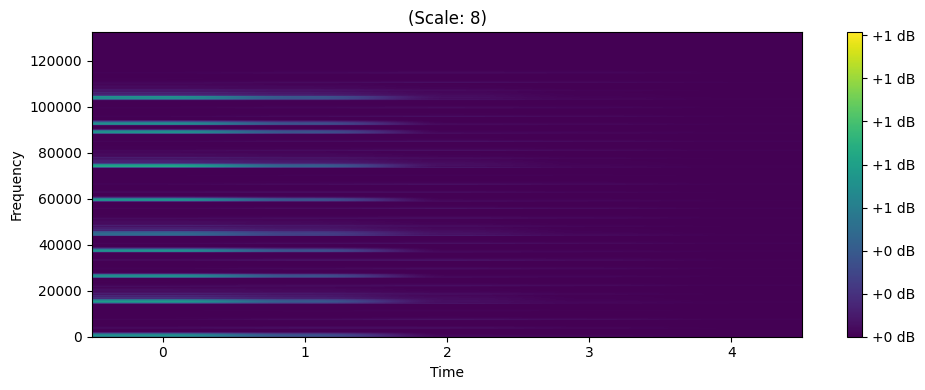

Processed Signal STFT:
{'shape': torch.Size([1, 5, 132287]), 'mean': 0.041404254734516144, 'std': 0.10621923208236694, 'min': 0.0, 'max': 1.3353172540664673}


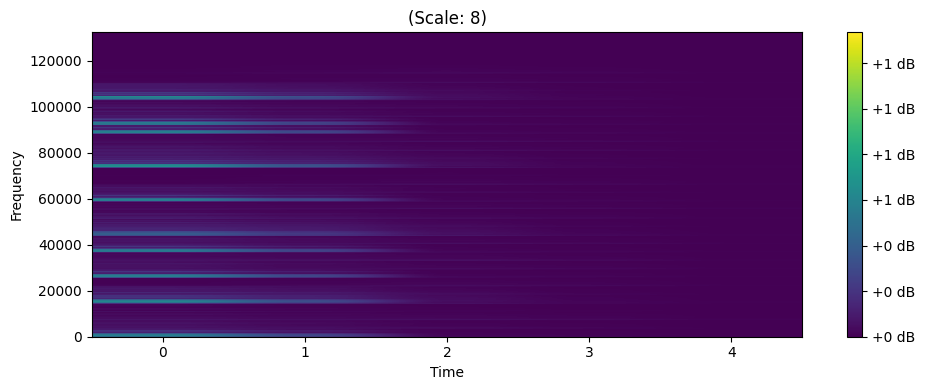

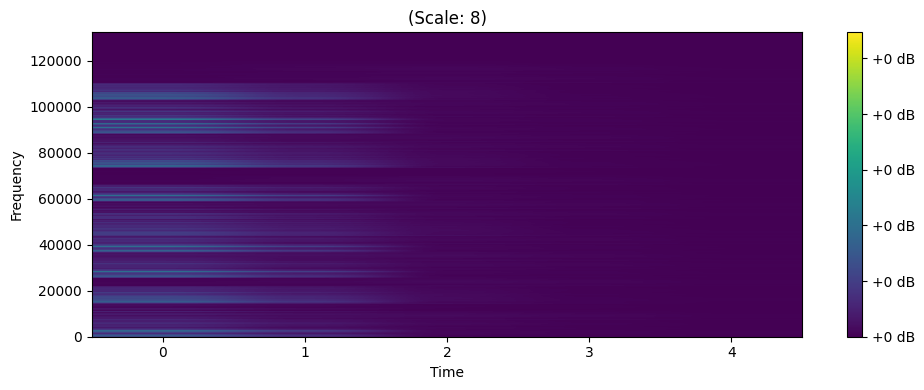

Linear distance: 0.3358345627784729
Log distance: 2.9195716381073


In [44]:
def summarize_stft(stft_tensor):
    return {
        "shape": stft_tensor.shape,
        "mean": torch.mean(stft_tensor).item(),
        "std": torch.std(stft_tensor).item(),
        "min": torch.min(stft_tensor).item(),
        "max": torch.max(stft_tensor).item(),
    }

scales = [2048,1024,512,256,128,64,32,16,8]
x_stfts = multiscale_stft(signal, scales, .75)
y_stfts = multiscale_stft(wet, scales, .75)

distance = spectral_distance(signal, wet)
print(f"Spectral distance between original and processed: {distance.item()}")

print("STFT Summary for Original and Processed Signals:")
for scale, x_stft, y_stft in zip(scales, x_stfts, y_stfts):
    print(f"\nScale: {scale}")
    print("Original Signal STFT:")
    print(summarize_stft(x_stft))
    plot_spectrogram(x_stft, scale)
    print("Processed Signal STFT:")
    print(summarize_stft(y_stft))
    plot_spectrogram(y_stft, scale)

     # Plot the distance spectrogram
    plot_distance_spectrogram(x_stft, y_stft, scale)

    print(f"Linear distance: {lin_distance(x_stft, y_stft)}")
    print(f"Log distance: {log_distance(x_stft, y_stft)}")
    